In [ ]:
# Зашумить изображение при помощи шума гаусса, постоянного шума.
# Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.
# Выяснить, какой фильтр показал лучший результат фильтрации шума.

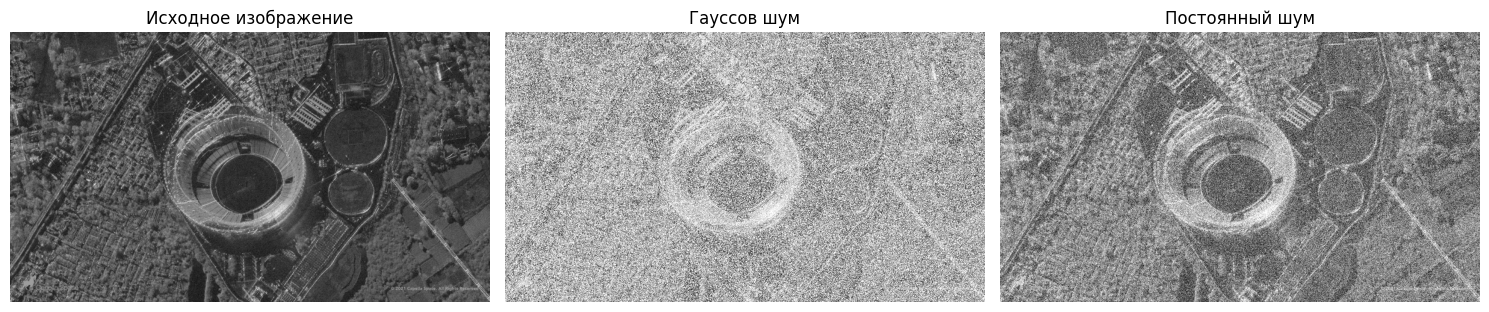

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, structural_similarity as ssim
#g
image_path = "sar_1.jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Файл {image_path} не найден.")


mean, sigma = 0, 25
noise_gauss = np.random.normal(mean, sigma, img.shape).astype(np.uint8)
img_gauss = cv2.add(img, noise_gauss)


a, b = 110, 0
mid = (a+b)/2
stdev = a - mid
noise_const = np.zeros(img.shape, np.float32)
cv2.randn(noise_const, mid, stdev)
img_const = np.clip(img.astype(np.float32)+noise_const, 0, 255).astype(np.uint8)


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Исходное изображение")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img_gauss, cmap='gray')
plt.title("Гауссов шум")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(img_const, cmap='gray')
plt.title("Постоянный шум")
plt.axis('off')
plt.tight_layout()
plt.show()


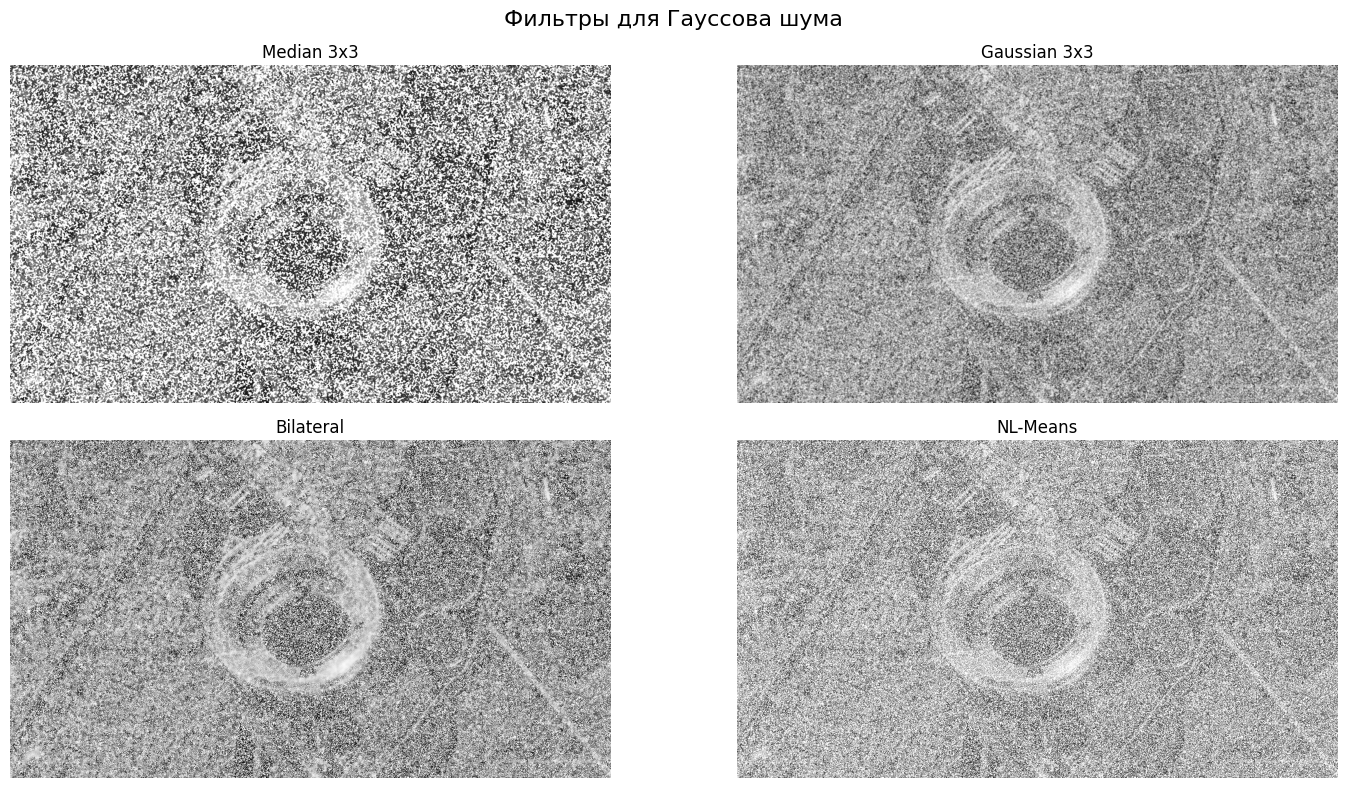

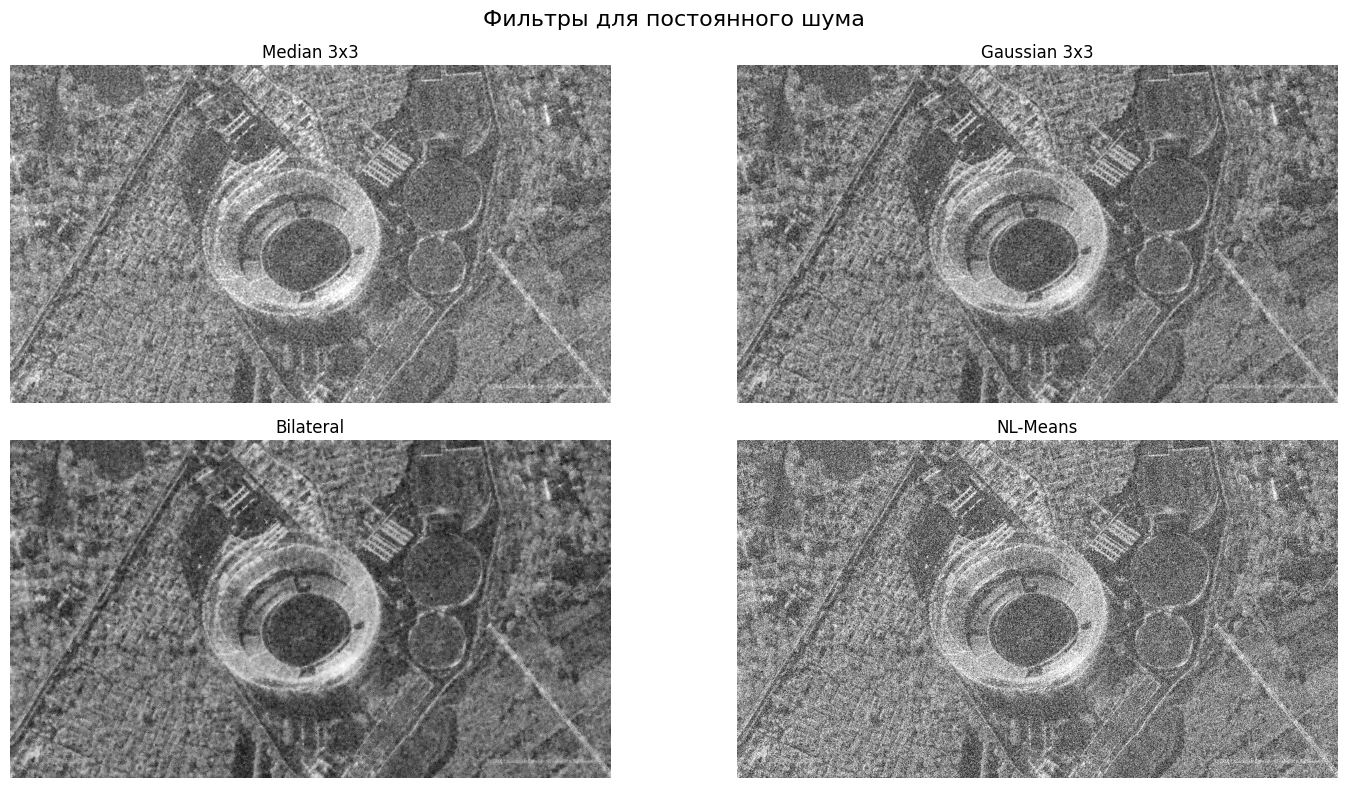

In [2]:
filters_gauss = {
    "Median 3x3": cv2.medianBlur(img_gauss, 3),
    "Gaussian 3x3": cv2.GaussianBlur(img_gauss, (3,3), 0),
    "Bilateral": cv2.bilateralFilter(img_gauss, 9, 75, 75),
    "NL-Means": cv2.fastNlMeansDenoising(img_gauss, None, 10, 7, 21)
}

filters_const = {
    "Median 3x3": cv2.medianBlur(img_const, 3),
    "Gaussian 3x3": cv2.GaussianBlur(img_const, (3,3), 0),
    "Bilateral": cv2.bilateralFilter(img_const, 9, 75, 75),
    "NL-Means": cv2.fastNlMeansDenoising(img_const, None, 10, 7, 21)
}

def plot_filters(filtered_dict, title):
    plt.figure(figsize=(15,8))
    plt.suptitle(title, fontsize=16)
    for i, (name, filtered) in enumerate(filtered_dict.items()):
        plt.subplot(2,2,i+1)
        plt.imshow(filtered, cmap='gray')
        plt.title(name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_filters(filters_gauss, "Фильтры для Гауссова шума")
plot_filters(filters_const, "Фильтры для постоянного шума")
